In [50]:
import nltk
from nltk.grammar import CFG
from nltk.parse.generate import generate

In [99]:
dictionary_group = [
    [['users'],[],['country','user type'],['new users', 'all users', 'returning users']],
    [['sessions', 'visits', 'pageviews'],[],['country','user type'],['new users', 'all users', 'returning users']],
    [['trials'],[],['plan'],['converted', 'churned']]
]

dates = ['this', 'last', 'month', 'day', 'week', 'year', 'january', 'february', 'march', 'april', 'may',\
         'june', 'july', 'august', 'september', 'october', 'november', 'december']

placeholders = ['show', 'me', 'please', 'hi', 'plot', 'hello', 'plz']

In [277]:
class DictionaryGroup:
    
    def __init__(self, metric_dictionary, dimension_dictionary, filter_dictionary, predefined_filter_dictionary):
        self.metric_dictionary = metric_dictionary
        self.  = dimension_dictionary
        self.filter_dictionary = filter_dictionary
        self.predefined_filter_dictionary = predefined_filter_dictionary
        

In [411]:
dictionary_group = DictionaryGroup(metric_dictionary, dimension_dictionary, filter_dictionary, predefined_filter_dictionary)

In [337]:
rules = ['M{m}', 
         'M{m} D{d1}', 'D{d1} M{m}', 'M{m} by D{d1}', 'D{d1} of M{m}',
         'S{s} M{m}', 'M{m} S{s}', 'M{m} for S{s}', 'S{s} M{m}', 
         'S{s} M{m} D{d1}', 'S{s} M{m} by D{d1}', 'M{m} for S{s} by D{d1}', 'M{m} by D{d1} for S{s}', 'M{m} by D{d1} S{s}', 'M{m} D{d1} S{s}',
         'M{m} by D{d1} and D{d2}', 'M{m} by D{d1} and by D{d2}', 'M{m} by D{d1} by D{d2}', 'M{m} D{d1} D{d2}', 'M{m} by D{d1} D{d2}', 'D{d1} of M{m} by D{d2}',
         'S{s} M{m} by D{d1} and D{d2}', 'S{s} M{m} by D{d1} and by D{d2}', 'S{s} M{m} by D{d1} by D{d2}', 'S{s} M{m} D{d1} D{d2}', 'S{s} M{m} by D{d1} D{d2}', 'D{d1} of S{s} M{m} by D{d2}']

In [412]:
class GrammarBuilder:
    
    def __init__(self, dictionary_groups):
        self.dictionary_groups = dictionary_groups

    def build_tokens_index(self):
        #extract all tokens
        self.tokens = {}
        for dictionary_group in self.dictionary_groups:
            for dictionary in [dictionary_group.metric_dictionary, 
                               dictionary_group.dimension_dictionary, 
                               dictionary_group.filter_dictionary, 
                               dictionary_group.predefined_filter_dictionary]:
                for element in dictionary:
                    for alias in element[1]:
                        for token in alias.split():
                            if token not in self.tokens:
                                self.tokens[token] = 'T{}'.format(len(self.tokens) + 1)

    def build_rules_from_tokens(self, dictionary_name, non_terminal_name):
        rules = []
        for dg in xrange(len(self.dictionary_groups)):
            dictionary_group = self.dictionary_groups[dg]
            dictionary = getattr(dictionary_group, dictionary_name)
            for i in range(len(dictionary)):
                element = dictionary[i]
                left_hand_expr = '{nt}{dg}_{element}'.format(nt = non_terminal_name, dg = dg+1, element = i+1)
                right_hand_expr = []
                for j in range(len(element[1])):
                    alias = element[1][j].split()
                    for subset in generate_all_subsets(alias):
                        tokens_ids = []
                        for token in subset:
                            tokens_ids.append(self.tokens[token])
                        right_hand_expr.append(' '.join(tokens_ids))
                right_hand_expr += ['PH {nt}{dg}_{element}'.format(nt = non_terminal_name, dg = dg+1, element = i+1),
                                        '{nt}{dg}_{element} PH'.format(nt = non_terminal_name, dg = dg+1, element = i+1)]
                right_hand_expr = ' | '.join(right_hand_expr)
                rules.append(' -> '.join([left_hand_expr, right_hand_expr]))
        return rules

    def build_grammar(self):
        grammar = []
        grammar.append('Q -> ' + ' | '.join(['Q{}'.format(i) for i in range(1, len(self.dictionary_groups) + 1)]))
        self.build_tokens_index()

        #add metrics
        grammar += self.build_rules_from_tokens('metric_dictionary', 'M')
        #add dimensions
        grammar += self.build_rules_from_tokens('dimension_dictionary', 'D')
        #add segments/predefined_filters
        grammar += self.build_rules_from_tokens('predefined_filter_dictionary', 'S')
        #add filters
        grammar += self.build_rules_from_tokens('filter_dictionary', 'F')
        #add tokens
        for token in self.tokens:
            left_hand_expr = self.tokens[token]
            right_hand_expr = """'{}'""".format(token)
            grammar.append(' -> '.join([left_hand_expr,  right_hand_expr]))

        #add rules
        for i in xrange(len(self.dictionary_groups)):
            dictionary_group = self.dictionary_groups[i]
            for m in xrange(len(dictionary_group.metric_dictionary)):
                for s in xrange(len(dictionary_group.predefined_filter_dictionary)):
                    for d1 in xrange(len(dictionary_group.dimension_dictionary)):
                        for d2 in xrange(len(dictionary_group.dimension_dictionary)):
                            if d1 != d2:
                                left_hand_expr = 'Q{}'.format(i+1)
                                for rule in rules:
                                    m_i = '{dg}_{m}'.format(dg = i+1, m = m+1)
                                    s_i = '{dg}_{s}'.format(dg = i+1, s = s+1)
                                    d1_i = '{dg}_{d1}'.format(dg = i+1, d1 = d1+1)
                                    d2_i = '{dg}_{d2}'.format(dg = i+1, d2 = d2+1)
                                    right_hand_expr = rule.format(m = m_i, s = s_i, d1 = d1_i, d2 = d2_i)
                                    grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
                                    
        #add placeholders
        left_hand_expr = 'PH'
        words = self.tokens.keys() + placeholders
        words = ["""'{}'""".format(word) for word in words]
        right_hand_expr = ' | '.join( words + ['PH PH'])
        grammar.append(' -> '.join([left_hand_expr,  right_hand_expr])) 

        return grammar      

In [ ]:
len(GrammarBuilder([dictionary_group]).build_grammar())

In [ ]:
grammar = CFG.fromstring('\n'.join(GrammarBuilder([dictionary_group]).build_grammar()))

In [ ]:
parser = nltk.ChartParser(grammar)

In [403]:
parsed = []
for tree in parser.parse(['users', 'type']):
    parsed.append(tree)

In [404]:
for p in parsed:
    print p

(Q (Q1 (M1_1 (M1_1 (T1 users)) (PH type))))
(Q (Q1 (M1_2 (M1_2 (T1 users)) (PH type))))
(Q (Q1 (M1_35 (M1_35 (T1 users)) (PH type))))


In [399]:
ans_tree = max(parsed, key=lambda x: - get_coverage(x))

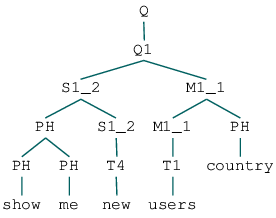

In [400]:
ans_tree

In [13]:
class DictionaryGroup:
    
    def __init__(self, metric_dictionary, dimension_dictionary, filter_dictionary, predefined_filter_dictionary):
        self.metric_dictionary = metric_dictionary
        self.dimension_dictionary  = dimension_dictionary
        self.filter_dictionary = filter_dictionary
        self.predefined_filter_dictionary = predefined_filter_dictionary
        

In [192]:
from itertools import permutations

class GrammarBuilder:
    
    def __init__(self, dictionary_groups):
        self.dictionary_groups = dictionary_groups
        self.__rules__ = []

    def __build_tokens_index(self):
        #extract all tokens
        self.tokens = {}
        for dictionary_group in self.dictionary_groups:
            for dictionary in [dictionary_group.metric_dictionary, 
                               dictionary_group.dimension_dictionary, 
                               dictionary_group.filter_dictionary, 
                               dictionary_group.predefined_filter_dictionary]:
                for element in dictionary:
                    for alias in element[1]:
                        for token in alias.split():
                            if token not in self.tokens:
                                self.tokens[token] = 'T{}'.format(len(self.tokens) + 1)
        
    def __build_rules_from_tokens(self, dictionary_name, non_terminal_name):
        for dg in xrange(len(self.dictionary_groups)):
            dictionary_group = self.dictionary_groups[dg]
            dictionary = getattr(dictionary_group, dictionary_name)
            left_hand_expr = '{nt}{dg}'.format(nt = non_terminal_name, dg = dg + 1)
            right_hand_expr = ['{nt}{dg}_{element}'.format(nt = non_terminal_name, 
                                                           dg = dg + 1, 
                                                           element = i + 1) 
                               for i in xrange(len(dictionary))] 
            right_hand_expr += [left_hand_expr + ' PH'] + ['PH ' + left_hand_expr]
            right_hand_expr = ' | '.join(right_hand_expr)
            self.grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
            for i in range(len(dictionary)):
                element = dictionary[i]
                left_hand_expr = '{nt}{dg}_{element}'.format(nt = non_terminal_name, 
                                                             dg = dg + 1, 
                                                             element = i + 1)
                self.reversed_index[left_hand_expr] = element[0]
                right_hand_expr = []
                for j in range(len(element[1])):
                    alias = element[1][j].split()
                    for subset in generate_all_subsets(alias):
                        tokens_ids = []
                        for token in subset:
                            tokens_ids.append(self.tokens[token])
                        right_hand_expr.append(' '.join(tokens_ids))
                right_hand_expr = ' | '.join(right_hand_expr)
                self.grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
                
    def __build_token_rules(self):
        for token in self.tokens:
            left_hand_expr = self.tokens[token]
            right_hand_expr = """'{}'""".format(token)
            self.grammar.append(' -> '.join([left_hand_expr,  right_hand_expr]))
            
    def __build_placeholder_rules(self):
        self.placeholders = ['show', 'me', 'please', 'hi', 'plot', 'hello', 'plz']
        left_hand_expr = 'PH'
        words = self.tokens.keys() + self.placeholders
        words = ["""'{}'""".format(word) for word in words]
        right_hand_expr = ' | '.join( words + ['PH PH'])
        self.grammar.append(' -> '.join([left_hand_expr,  right_hand_expr])) 
            
    def __build_date_rules(self):
        self.date_tokens = ['this', 'last', 'month', 'day', 'week', 'year', 'january', 
                            'february', 'march', 'april', 'may', 'june', 'july', 'august',
                            'september', 'october', 'november', 'december', 'today']
        left_hand_expr = 'DT'
        right_hand_expr = ['DT DT', 'PH DT', 'DT PH', ''''for' DT'''] + ["""'{}'""".format(date) for date in self.date_tokens]
        right_hand_expr = (' | ').join(right_hand_expr)
        self.grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
            
    def __build_grammar_rules(self):
        self.rules = ['''M{n}''',
                      '''M{n} D{n}''',
                      '''M{n} 'by' D{n}''', 
                      '''M{n} 'for' S{n}''', 
                      '''S{n} M{n} ''',
                      '''M{n} 'for' S{n}''',
                      '''M{n} 'by' D{n} 'for' S{n}''',
                      '''D{n} 'of' M{n}''',
                      '''D{n} 'of' M{n} for S{n}''',
                      '''D{n} 'of' S{n} M{n}''',
                      '''M{n} 'by' D{n} 'for' S{n}''', 
                      '''S{n} M{n} 'by' D{n}''',
                      '''M{n} 'by' D{n} 'and' D{n}''',
                      '''M{n} 'by' D{n} 'by' D{n}''', 
                      '''M{n} 'by' D{n} D{n}''',
                      '''M{n} D{n} D{n}''',
                      '''S{n} M{n} 'by' D{n} 'and' D{n}''',
                      '''S{n} M{n} 'by' D{n} 'by' D{n}''', 
                      '''S{n} M{n} 'by' D{n} D{n}''',
                      '''S{n} M{n} D{n} D{n}''', 
                      '''M{n} 'for' S{n} 'by' D{n} 'and' D{n}''',
                      '''M{n} 'for' S{n} 'by' D{n} 'by' D{n}''', 
                      '''M{n} 'for' S{n} 'by' D{n} D{n}''',
                      '''M{n} 'for' S{n} D{n} D{n}''',
                      '''M{n} 'by' D{n} 'and' D{n} 'for' S{n}''',
                      '''M{n} 'by' D{n} 'by' D{n} 'for' S{n}''', 
                      '''M{n} 'by' D{n} D{n} 'for' S{n}''',
                      '''M{n} D{n} D{n} 'for' S{n}'''
                     ]
        #add date to all rules at every position
        rules_with_date = []
        for rule in self.rules:
            num_of_tokens = len(rule.split())
            for i in xrange(num_of_tokens + 1):
                new_rule = rule.split()
                new_rule.insert(i, 'DT')
                rules_with_date.append(' '.join(new_rule))
        
        for dg in xrange(len(self.dictionary_groups)):
            left_hand_expr = 'Q{dg}'.format(dg = dg + 1)
            right_hand_expr = [rule.format(n = dg + 1) for rule in self.rules + rules_with_date]
            right_hand_expr = ' | '.join(right_hand_expr)
            self.grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
    
    def __build_dictionary_group_rules(self):
        self.grammar.append('Q -> ' + ' | '.join(['Q{}'.format(i) 
                                                  for i in range(1, len(self.dictionary_groups) + 1)]))
        
    def __build_analytical_components_rules(self):
        self.__build_tokens_index()
        self.reversed_index = {}
        #add metrics
        self.__build_rules_from_tokens('metric_dictionary', 'M')
        #add dimensions
        self.__build_rules_from_tokens('dimension_dictionary', 'D')
        #add segments/predefined_filters
        self.__build_rules_from_tokens('predefined_filter_dictionary', 'S')
        #add filters
        self.__build_rules_from_tokens('filter_dictionary', 'F')
        

    def build_grammar(self):
        # Initilize grammar.
        self.grammar = []
        # Add rules like Q -> Q1 | Q2 | ... .
        self.__build_dictionary_group_rules()
        # Add rules like Q1 -> M1 by D1 for S1 DT.
        self.__build_grammar_rules()
        # Add rules like M1 -> M1_1 | M1_2 | ... | PH M1,
        #                M1_1 -> T1 | T1 T2 | ... .
        self.__build_analytical_components_rules()
        # Add rules like T1 -> 'users | 'sessions' | ... .
        self.__build_token_rules()
        # Add rules like DT -> 'month' | ... | DT DT.
        self.__build_date_rules()
        # Add rules like PH -> 'show' | ... | PH PH.                       
        self.__build_placeholder_rules()

        return self.grammar
    
def generate_all_subsets(arr):
    ans = []
    for i in range(len(arr)):
        ans += permutations(arr, i + 1)
    return ans

In [188]:
dictionary_group = DictionaryGroup(metric_dictionary, 
                                   dimension_dictionary, 
                                   filter_dictionary, 
                                   predefined_filter_dictionary)

In [ ]:
from datetime

In [190]:
grammar_builder = GrammarBuilder([dictionary_group])
rules = grammar_builder.build_grammar()

In [177]:
import nltk
from nltk.grammar import CFG
from nltk.parse.generate import generate

grammar = CFG.fromstring('\n'.join(GrammarBuilder([dictionary_group]).build_grammar()))
parser = nltk.ChartParser(grammar)
grammar

<Grammar with 14425 productions>

In [181]:
parsed = []
for tree in parser.parse(['show', 'me', 'new','users', 'by', 'type', 'and', 'source', 'for', 'this', 'week']):
    parsed.append(tree)

In [182]:
ans_tree = max(parsed, key=lambda x: - get_coverage(x))

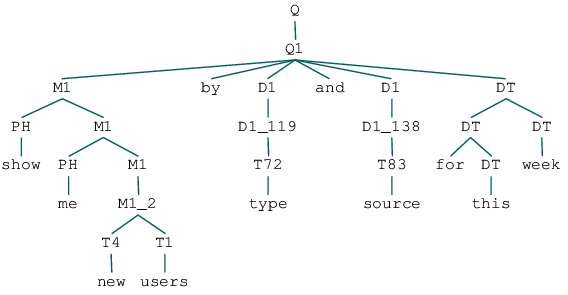

In [183]:
ans_tree

In [178]:
def build_grammar(dictionary_group):
    grammar = []
    grammar.append('Q -> ' + ' | '.join(['Q{}'.format(i) for i in range(1, len(dictionary_group) + 1)]))
    
    tokens = {}
    for i in range(len(dictionary_group)):
        for j in range(4):
            for k in range(len(dictionary_group[i][j])):
                for token in dictionary_group[i][j][k].split():
                    if token not in tokens:
                        tokens[token] = 'T{}'.format(len(tokens) + 1)
    
    for i in range(len(dictionary_group)):
        grammar.append('''Q{n} -> M{n} | M{n} 'by' D{n} | M{n} 'by' D{n} and D{n} | M{n} 'for' S{n} | S{n} M{n} | M{n} 'by' D{n} 'for' S{n} | S{n} M{n} 'by' D{n}'''.format(n = i+1))
        grammar.append('''Q{n} -> M{n} DT| M{n} 'by' D{n} DT | M{n} 'by' D{n} and D{n} |  M{n} 'for' S{n} DT | S{n} M{n} DT | M{n} 'by' D{n} 'for' S{n} DT | S{n} M{n} 'by' D{n} DT'''.format(n = i+1))

    #add metrics
    for i in xrange(len(dictionary_group)):
        left_hand_expr = 'M{}'.format(i+1)
        right_hand_expr = []
        for j in xrange(len(dictionary_group[i][0])):
            for subset in generate_all_subsets(dictionary_group[i][0][j].split()):
                tokens_ids = []
                for token in subset:
                    tokens_ids.append(tokens[token])
                right_hand_expr.append(' '.join(tokens_ids))
        right_hand_expr += ['PH M{}'.format(i+1), 'M{} PH'.format(i+1)]
        right_hand_expr = ' | '.join(right_hand_expr)
        grammar.append(' -> '.join((left_hand_expr, right_hand_expr)))
    
    #add dimensions
    for i in xrange(len(dictionary_group)):
        left_hand_expr = 'D{}'.format(i+1)
        right_hand_expr = []
        for j in xrange(len(dictionary_group[i][2])):
            for subset in generate_all_subsets(dictionary_group[i][2][j].split()):
                tokens_ids = []
                for token in subset:
                    tokens_ids.append(tokens[token])
                right_hand_expr.append(' '.join(tokens_ids))
        right_hand_expr += ['PH D{}'.format(i+1), 'D{} PH'.format(i+1)]
        right_hand_expr = ' | '.join(right_hand_expr)
        grammar.append(' -> '.join((left_hand_expr, right_hand_expr)))
        
    #add segments
    for i in xrange(len(dictionary_group)):
        left_hand_expr = 'S{}'.format(i+1)
        right_hand_expr = []
        for j in xrange(len(dictionary_group[i][3])):
            for subset in generate_all_subsets(dictionary_group[i][3][j].split()):
                tokens_ids = []
                for token in subset:
                    tokens_ids.append(tokens[token])
                right_hand_expr.append(' '.join(tokens_ids))
        right_hand_expr += ['PH S{}'.format(i+1), 'S{} PH'.format(i+1)]
        right_hand_expr = ' | '.join(right_hand_expr)
        grammar.append(' -> '.join((left_hand_expr, right_hand_expr)))\
    
    #add dates
    left_hand_expr = 'DT'
    right_hand_expr = (' | ').join(['DT DT'] + ["""'{}'""".format(date) for date in dates])
    grammar.append(' -> '.join([left_hand_expr, right_hand_expr]))
    
    #add tokens
    for token in tokens:
        left_hand_expr = tokens[token]
        right_hand_expr = """'{}'""".format(token)
        grammar.append(' -> '.join([left_hand_expr,  right_hand_expr]))
        
    #add placeholders
    left_hand_expr = 'PH'
    words = tokens.keys() + placeholders
    words = ["""'{}'""".format(word) for word in words]
    right_hand_expr = ' | '.join(+ ['PH PH'])
    grammar.append(' -> '.join([left_hand_expr,  right_hand_expr])) 
    
    return grammar

In [179]:
build_grammar(dictionary_group)

['Q -> Q1 | Q2 | Q3',
 "Q1 -> M1 | M1 'by' D1 | M1 'by' D1 'and' D1 | S1 M1 'by' D1 'and' D1 | M1 'for' S1 | S1 M1 | M1 'by' D1 'for' S1 | S1 M1 'by' D1",
 "Q1 -> M1 DT | M1 'by' D1 DT | M1 'by' D1 'and' D1 DT | S1 M1 'by' D1 'and' D1 DT |  M1 'for' S1 DT | S1 M1 DT | M1 'by' D1 'for' S1 DT | S1 M1 'by' D1 DT",
 "Q2 -> M2 | M2 'by' D2 | M2 'by' D2 'and' D2 | S2 M2 'by' D2 'and' D2 | M2 'for' S2 | S2 M2 | M2 'by' D2 'for' S2 | S2 M2 'by' D2",
 "Q2 -> M2 DT | M2 'by' D2 DT | M2 'by' D2 'and' D2 DT | S2 M2 'by' D2 'and' D2 DT |  M2 'for' S2 DT | S2 M2 DT | M2 'by' D2 'for' S2 DT | S2 M2 'by' D2 DT",
 "Q3 -> M3 | M3 'by' D3 | M3 'by' D3 'and' D3 | S3 M3 'by' D3 'and' D3 | M3 'for' S3 | S3 M3 | M3 'by' D3 'for' S3 | S3 M3 'by' D3",
 "Q3 -> M3 DT | M3 'by' D3 DT | M3 'by' D3 'and' D3 DT | S3 M3 'by' D3 'and' D3 DT |  M3 'for' S3 DT | S3 M3 DT | M3 'by' D3 'for' S3 DT | S3 M3 'by' D3 DT",
 'M1 -> T1 | PH M1 | M1 PH',
 'M2 -> T8 | T9 | T10 | PH M2 | M2 PH',
 'M3 -> T11 | PH M3 | M3 PH',
 'D1 -

In [180]:
grammar = CFG.fromstring('\n'.join(build_grammar(dictionary_group)))

In [181]:
parser = nltk.ChartParser(grammar)

In [233]:
parsed = []
for tree in parser.parse(['show', 'me','new','users', 'by', 'user','type', 'and', 'country', 'this', 'month']):
    parsed.append(tree)

In [57]:
def get_coverage(tree):
    ph_count = 0
    for subtree in tree.subtrees():
        count = 0
        for i in subtree.subtrees():
            count += 1
        if count == 1:
            ph_count += int(subtree.label() == 'PH')
    return ph_count

ans_tree = max(parsed, key=lambda x: - get_coverage(x))

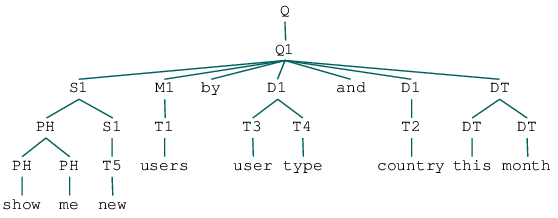

In [267]:
ans_tree

In [272]:
import re

def extract_query(tree):
    metric = None
    segments = set()
    dimensions = set()
    
    for subtree in tree.subtrees():
        h = subtree.height()
        if h == 3 and re.match("M\d\d*", subtree.label()) is not None:
            metric = ' '.join(subtree.leaves())
            continue
        if h == 3 and re.match("D\d\d*", subtree.label()) is not None:
            dimensions.add(' '.join(subtree.leaves()))
            continue
        if h == 3 and re.match("S\d\d*", subtree.label()) is not None:
            segments.add(' '.join(subtree.leaves()))
            continue
    return [metric, list(dimensions), list(segments)]

extract_query(ans_tree)

['users', ['country', 'user type'], ['new']]

In [252]:
re.match("M\d\d*", 'M1') is not None

True

In [88]:
grammar = CFG.fromstring("""
    Q -> Q1 | Q2 | Q3
    Q1 -> M1 | M1 'by' D1 | M1 'for' S1 | S1 M1 | M1 'by' D1 'for' S1 | S1 M1 'by' D1
    Q2 -> M2 | M2 'by' D2 | M2 'for' S2 | S2 M2 | M2 'by' D2 'for' S2 | S2 M2 'by' D2
    Q3 -> M3 | M3 'by' D3 | M3 'for' S3 | S3 M3 | M3 'by' D3 'for' S3 | S3 M3 'by' D3
    M1 -> MT1_1 | null
    M2 -> MT2_1 | MT2_2 | MT2_3 
    M3 -> MT3_1
    D1 -> DT1_1 | DT1_2 | DT1_3 | DT1_2 DT1_3
    D2 -> DT2_1 | DT2_2 | DT2_3 | DT2_2 DT2_3
    D3 -> DT3_1
    S1 -> ST1_1 | ST1_2 | ST1_3 | ST1_1 ST1_4 |  ST1_2 ST1_4 |  ST1_3 ST1_4
    S2 -> ST12_1 | ST2_2 | ST2_3 | ST2_1 ST2_4 |  ST2_2 ST2_4 |  ST2_3 ST2_4
    S3 -> ST3_1 | ST3_2
    MT1_1 -> 'users'
    MT2_1 -> 'sessions'
    MT2_2 -> 'visits' 
    MT2_3 -> 'pageviews'
    MT3_1 -> 'trials'
    DT1_1 -> 'country'
    DT1_2 -> 'user'
    DT1_3 -> 'type'
    DT2_1 -> 'country'
    DT2_2 -> 'user'
    DT2_3 -> 'type'
    DT3_1 -> 'plan'
    ST1_1 -> 'new'
    ST1_2 -> 'all'
    ST1_3 -> 'returning'
    ST1_4 -> 'users'
    ST2_1 -> 'new'
    ST2_2 -> 'all'
    ST2_3 -> 'returning'
    ST2_4 -> 'users'
    ST3_1 -> 'converted'
    ST3_2 -> 'churned'
    """)

In [89]:
from nltk.parse.generate import generate
for g in generate(grammar, n=1000):
    print g

[u'users']
[u'users', u'by', u'country']
[u'users', u'by', u'user']
[u'users', u'by', u'type']
[u'users', u'by', u'user', u'type']
[u'users', u'for', u'new']
[u'users', u'for', u'all']
[u'users', u'for', u'returning']
[u'users', u'for', u'new', u'users']
[u'users', u'for', u'all', u'users']
[u'users', u'for', u'returning', u'users']
[u'new', u'users']
[u'all', u'users']
[u'returning', u'users']
[u'new', u'users', u'users']
[u'all', u'users', u'users']
[u'returning', u'users', u'users']
[u'users', u'by', u'country', u'for', u'new']
[u'users', u'by', u'country', u'for', u'all']
[u'users', u'by', u'country', u'for', u'returning']
[u'users', u'by', u'country', u'for', u'new', u'users']
[u'users', u'by', u'country', u'for', u'all', u'users']
[u'users', u'by', u'country', u'for', u'returning', u'users']
[u'users', u'by', u'user', u'for', u'new']
[u'users', u'by', u'user', u'for', u'all']
[u'users', u'by', u'user', u'for', u'returning']
[u'users', u'by', u'user', u'for', u'new', u'users']
[u'

In [34]:
generate(grammar, n=10)

In [92]:
parser = nltk.ChartParser(grammar)

In [100]:
for tree in parser.parse(['new','users', 'by', 'type']):
    print tree

(Q (Q1 (S1 (ST1_1 new)) (M1 (MT1_1 users)) by (D1 (DT1_3 type))))


In [108]:
a = ['aaaa','bbb', 'aaa', "aAAA", 'd']
a.sort()
a

['aAAA', 'aaa', 'aaaa', 'bbb', 'd']

In [109]:
min(a)

'aAAA'

In [30]:
grammar.productions()

[Q -> Q1,
 Q -> Q2,
 Q -> Q3,
 Q1 -> M1,
 Q1 -> M1 'by' D1,
 Q1 -> M1 'for' S1,
 Q1 -> S1 M1,
 Q1 -> M1 'by' D1 'for' S1,
 Q1 -> S1 M1 'by' D1,
 Q2 -> M2,
 Q2 -> M2 'by' D2,
 Q2 -> M2 'for' S2,
 Q2 -> S2 M2,
 Q2 -> M2 'by' D2 'for' S2,
 Q2 -> S2 M2 'by' D2,
 Q3 -> M3,
 Q3 -> M3 'by' D3,
 Q3 -> M3 'for' S3,
 Q3 -> S3 M3,
 Q3 -> M3 'by' D3 'for' S3,
 Q3 -> S3 M3 'by' D3,
 M1 -> MT1,
 M1 -> MT1 MT1,
 M2 -> MT2,
 M2 -> MT2 MT2,
 M3 -> MT3,
 M3 -> MT3 MT3,
 D1 -> DT1,
 D1 -> DT1 DT1,
 D2 -> DT2,
 D2 -> DT2 DT2,
 D3 -> DT3,
 D3 -> DT3 DT3,
 S1 -> ST1,
 S1 -> ST1 ST1,
 S2 -> ST2,
 S2 -> ST2 ST2,
 S3 -> ST3,
 S3 -> ST3 ST3,
 MT1 -> users,
 MT2 -> sessions,
 MT2 -> visits,
 MT2 -> pageviews,
 MT3 -> trials,
 DT1 -> country,
 DT1 -> user,
 DT1 -> type,
 DT2 -> country,
 DT2 -> user,
 DT2 -> type,
 DT3 -> plan,
 ST1 -> new,
 ST1 -> all,
 ST1 -> returning,
 ST2 -> new,
 ST2 -> all,
 ST2 -> returning,
 ST3 -> converted,
 ST3 -> churned]